### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

### Переходим к практике

Три ячейки ниже делаем в Google Colaboratory

- установим razdel
- установим pymorphy2

In [ ]:
# !pip install razdel

In [ ]:
# !pip install pymorphy2

In [ ]:
# !pip install gensim

In [ ]:
# !pip install nltk

Делаем доступ к Googl Drive

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("/home/vyacheslav/Рабочий стол/Data Scientist/IV ЧЕТВЕРТЬ/I. Машинное обучение в бизнесе/2 lesson/2/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("/home/vyacheslav/Рабочий стол/Data Scientist/IV ЧЕТВЕРТЬ/I. Машинное обучение в бизнесе/2 lesson/2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vyacheslav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('/home/vyacheslav/Рабочий стол/Data Scientist/IV ЧЕТВЕРТЬ/I. Машинное обучение в бизнесе/2 lesson/2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 26 s, sys: 1 s, total: 27 s
Wall time: 27 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 29s, sys: 280 ms, total: 3min 29s
Wall time: 3min 29s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[5]

'банк'

In [14]:
common_corpus[0][0]

(0, 5)

In [15]:
len(texts[0])

118

Все просто - это словарь наших слов

Запускаем обучение

In [16]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 34s, sys: 51.8 s, total: 2min 26s
Wall time: 50.3 s


In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(4, 0.07599083),
 (7, 0.26146066),
 (11, 0.035437163),
 (12, 0.37873653),
 (15, 0.048369575),
 (16, 0.092914715),
 (18, 0.055247936),
 (24, 0.03402242)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: земля обнаружить погибнуть произойти статья житель данные
topic_1: россия nn российский сша научный военный журнал
topic_2: украина станция министерство украинский область запустить восток
topic_3: ребёнок жизнь гражданин метод товар семья новый
topic_4: всё исследование очень эксперт день американский первый
topic_5: торговый разместить брюссель сустав иерусалим межконтинентальный башкортостан
topic_6: система оборудование иск вуз академия министерство сша
topic_7: банк экономика тыс рынок управление доля система
topic_8: ракета конкурс вирус супруг устойчивость эндрю граница
topic_9: фонд район лицо власть закон документ уголовный
topic_10: цена рост доллар млн ставка инвестиция писать
topic_11: снижение смерть государство армия медведев египет писать
topic_12: налог планета бомба превысить автомобиль университет образовать
topic_13: белый вицепремьер снять характерный бежать австралийский палатка
topic_14: млрд развитие проект правительство население министр объём
topic_15:

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [20]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'nn',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [21]:
lda[common_dictionary.doc2bow(news['title'].iloc[5])]

[(2, 0.04772417),
 (4, 0.33017027),
 (12, 0.22195283),
 (23, 0.32623824),
 (24, 0.059925444)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [22]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.389958,0.018677,0.0,0.000000,0.0,0.0,0.443830,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,4896,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.093699,0.0,0.084419,0.0,0.0,0.0,0.641693,0.000000,0.000000
2,4897,0.0,0.000000,0.000000,0.0,0.076027,0.0,0.0,0.261432,0.0,...,0.048366,0.092916,0.0,0.055262,0.0,0.0,0.0,0.000000,0.000000,0.034055
3,4898,0.0,0.000000,0.000000,0.0,0.791497,0.0,0.0,0.000000,0.0,...,0.000000,0.110546,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,4899,0.0,0.087485,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.102875,0.000000,0.0,0.103353,0.0,0.0,0.0,0.000000,0.089793,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [25]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [26]:
doc_dict[293622]

array([0.02261937, 0.28531963, 0.        , 0.        , 0.15741858,
       0.        , 0.        , 0.        , 0.03791562, 0.0474574 ,
       0.        , 0.        , 0.10466859, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.10917789, 0.        ,
       0.        , 0.        , 0.22387992, 0.        , 0.        ])

In [129]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [130]:
get_user_embedding(user_articles_list)

array([0.        , 0.7064001 , 0.01903539, 0.10667321, 0.30836666,
       0.        , 0.01217667, 0.09307117, 0.        , 0.32853934,
       0.0189825 , 0.0711334 , 0.        , 0.01539133, 0.19243041,
       0.04383247, 0.30049571, 0.42345628, 0.        , 0.        ,
       0.09103619, 0.02247648, 0.15253119, 0.01204898, 0.06574853])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

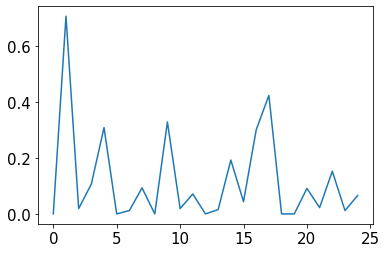

In [131]:
import matplotlib.pyplot as plt
plt.plot(get_user_embedding(user_articles_list))

In [132]:
#users['articles'].iloc[33]

In [133]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [134]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.216159,0.468582,0.337873,0.207863,0.157419,0.0,0.115225,0.121721,0.073998,...,0.372418,0.000000,0.104120,0.254491,0.0000,0.000000,0.000000,0.223880,0.0,0.055765
1,u108690,0.062978,0.470682,0.310886,0.147680,0.243931,0.0,0.042088,0.072113,0.000000,...,0.095847,0.076737,0.179701,0.084731,0.0000,0.000000,0.054582,0.067629,0.0,0.065574
2,u108339,0.239760,0.526584,0.256582,0.112721,0.107411,0.0,0.000000,0.048705,0.000000,...,0.093519,0.082507,0.118496,0.067270,0.0158,0.199195,0.012450,0.154870,0.0,0.043508


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [135]:
target = pd.read_csv("/home/vyacheslav/Рабочий стол/Data Scientist/IV ЧЕТВЕРТЬ/I. Машинное обучение в бизнесе/2 lesson/2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [136]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.216159,0.468582,0.337873,0.207863,0.157419,0.0,0.115225,0.121721,0.073998,...,0.000000,0.104120,0.254491,0.0000,0.000000,0.000000,0.223880,0.0,0.055765,0
1,u108690,0.062978,0.470682,0.310886,0.147680,0.243931,0.0,0.042088,0.072113,0.000000,...,0.076737,0.179701,0.084731,0.0000,0.000000,0.054582,0.067629,0.0,0.065574,1
2,u108339,0.239760,0.526584,0.256582,0.112721,0.107411,0.0,0.000000,0.048705,0.000000,...,0.082507,0.118496,0.067270,0.0158,0.199195,0.012450,0.154870,0.0,0.043508,1


In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [138]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [139]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [140]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.04506393, 0.00470995, 0.7698383 , 0.39411077, 0.02680162,
       0.02071922, 0.03248853, 0.09084056, 0.02290044, 0.35275465])

In [141]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [142]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
precision_.append(precision[ix])
recall_.append(recall[ix])
fscore_.append(fscore[ix])

Best Threshold=0.287516, F-Score=0.774, Precision=0.703, Recall=0.861


In [143]:
import itertools

In [144]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1666   89]
 [  35  210]]


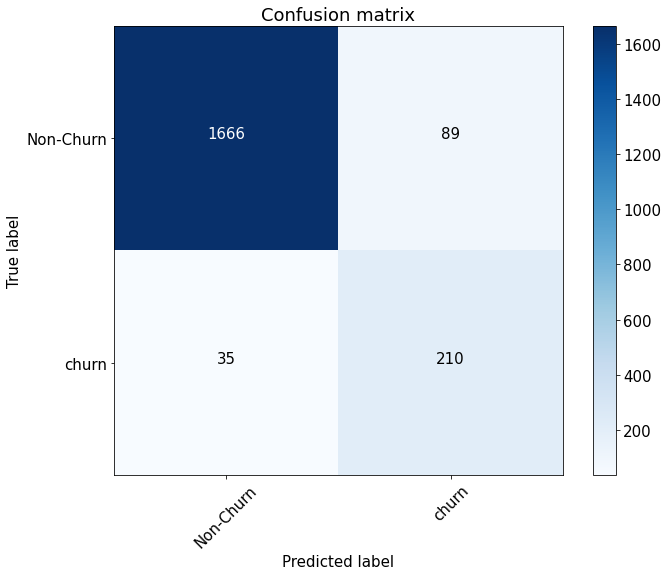

In [145]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [146]:
roc_auc_score(y_test, preds)

0.9730495959067388

In [147]:
roc_auc.append(roc_auc_score(y_test, preds))

In [148]:
print(precision_)
print(recall_)
print(fscore_)
print(roc_auc)

[0.6831275720164609, 0.7992125984251969, 0.7033333333333334]
[0.6775510204081633, 0.8285714285714286, 0.8612244897959184]
[0.6803278688524591, 0.8136272545090181, 0.7743119266055047]
[0.9499901157044014, 0.9783289726146869, 0.9730495959067388]


#### Создадим словари для соответствующих метрик precision, recall, fscore, roc_auc

In [89]:
precision_ = []
recall_ = []
fscore_ = []
roc_auc = []

##### Модифицируем функцию из урока и последовательно выполним 3 расчета. Далее построим таблицу с результатами и сделаем выводы

In [172]:
print(f'| RESULTS  | PRECISION | RECALL | FSCORE | ROC_AUC |')
print(f'|   MEAN   |    {precision_[0]:.2f}   |  {recall_[0]:.2f}  |  {fscore_[0]:.2f}  |  {roc_auc[0]:.2f}   |')
print(f'|  MEDIAN  |    {precision_[1]:.2f}   |  {recall_[1]:.2f}  |  {fscore_[1]:.2f}  |  {roc_auc[1]:.2f}   |')
print(f'|   MAX    |    {precision_[2]:.2f}   |  {recall_[2]:.2f}  |  {fscore_[2]:.2f}  |  {roc_auc[2]:.2f}   |')

| RESULTS  | PRECISION | RECALL | FSCORE | ROC_AUC |
|   MEAN   |    0.68   |  0.68  |  0.68  |  0.95   |
|  MEDIAN  |    0.80   |  0.83  |  0.81  |  0.98   |
|   MAX    |    0.70   |  0.86  |  0.77  |  0.97   |


### ВЫВОД: 1. PRECISION и RECALL достаточно хороши и лучше всего при использовании медианных значений, что говорит о том, что алгоритм работает без учета выбросов и использует основные темы пользователя. Это подверждает и f-мера и roc_auc. Однако, учет только топовых тем пользователя тоже показал достаточно неплохой результат. Хуже всего результат при использовании усреднения. Это может говорить о том, что пользователь просто так посмотрел некоторые темы, не являющиеся зоной его интересов, посмотрел между прочим, а мы на них уже среагировали. Общий вывод - построенная модель хороша на высоком уровне.

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk